# Cost functions

We give an in-depth guide on how to use the builtin cost functions.

The iminuit package comes with a couple of common cost functions that you can import from `iminuit.cost` for convenience. Of course, you can write your own cost functions to use with iminuit, but most of the cost function is always the same. What really varies is the statistical model which predicts the probability density as a function of the parameter values. This you still have to provide yourself and the iminuit package will not include machinery to build statistical models (that is out of scope).

Using the builtin cost functions is not only convenient, they also have some extra features.

* Support of fitted weighted histograms.
* Technical tricks improve numerical stability.
* Optional numba acceleration (if numba is installed).
* Cost functions can be added to fit data sets with shared parameters.
* Temporarily mask data.

We demonstrate each cost function on an standard example from high-energy physics, the fit of a peak over some smooth background (here taken to be constant).

In [1]:
from iminuit import cost, Minuit
from numba_stats import norm, uniform # faster replacements for scipy.stats functions
import numpy as np
from matplotlib import pyplot as plt

We generate our data. We sample from a Gaussian peak around 0 with width 0.1 and from uniform background from -1 to 1. We then bin the original data. One can fit the original or the binned data. The latter is often much faster and if the binning is fine enough, there is no loss in precision as we will see.

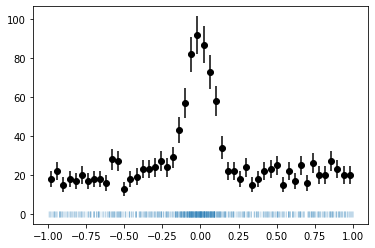

In [2]:
xrange = -1, 1

rng = np.random.default_rng(1)

xdata = rng.normal(0, 0.1, size=400)
xdata = np.append(xdata, rng.uniform(*xrange, size=1000))

n, xe = np.histogram(xdata, bins=50, range=xrange)
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.plot(xdata, np.zeros_like(xdata), "|", alpha=0.1);

## Maximum-likelihood fits

Maximum-likelihood fits are the state-of-the-art when it comes to fitting models to data. The can be applied to unbinned and binned data (histograms).

* Unbinned fits are the easiest to use, because they can be apply directly to the raw sample. They become slow when the sample size is large.
* Binned fits require you to appropriately bin the data. The binning has to be fine enough to retain all essential information. Binned fits are much faster when the sample size is large.

### Unbinned fit

Unbinned fits are ideal when the data samples are not too large or very high dimensional. There is no need to worry about the appropriate binning of the data. Unbinned fits are inefficient when the samples are very large and can become numerically unstable, too. Binned fits are a better choice then.

The cost function for an unbinned maximum-likelihood fit is really simple, it is the sum of the logarithm of the pdf evaluated at each sample point (times -1 to turn maximimization into minimization). You can easily write this yourself, but a naive implementation will suffer from instabilities when the pdf becomes locally zero. Our implementation mitigates the instabilities to some extend.

To perform the unbinned fit you need to provide the pdf of the model, which must be vectorized (a numpy ufunc). The pdf must be normalized, which means that the integral over the sample value range must be a constant for any combination of model parameters.

The model pdf in this case is the weighted sum of the normal and the uniform pdfs. The parameters are $z$ (the weight), $\mu$ and $\sigma$ of the normal distribution. The uniform distribution is parameter-free. The cost function detects the parameter names.

It is important to put appropriate limits on the parameters, so that the problem does not become mathematically undefined.
* $0 < z < 1$,
* $-1 < \mu < 1$,
* $\sigma > 0$.

In [3]:
def model_pdf(x, z, mu, sigma):
    return (z * norm.pdf(x, mu, sigma) + 
            (1 - z) * uniform.pdf(x, xrange[0], xrange[1] - xrange[0]))

c = cost.UnbinnedNLL(xdata, model_pdf)

m = Minuit(c, z=0.4, mu=0, sigma=0.2)
m.limits["z"] = (0, 1)
m.limits["mu"] = (-1, 1)
m.limits["sigma"] = (0, None)

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1504                       │              Nfcn = 83               │
│ EDM = 3.42e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.275   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.009   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000298 -3.66e-06  3.73e-05 │
│    mu │ -3.66e-06  3.79e-05 -2.32e-06 │
│ sigma │  3.73e-05 -2.32e-06  3.22e-05 │
└───────┴───────────────────────────────┘

We visualize the fit.

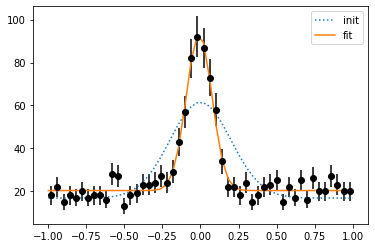

In [4]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(xe[0], xe[-1])
plt.plot(xm, model_pdf(xm, *[p.value for p in m.init_params]) * len(xdata) * dx[0],
         ls=":", label="init")
plt.plot(xm, model_pdf(xm, *m.values) * len(xdata) * dx[0], label="fit")
plt.legend();

### Extended unbinned fit

An important variant of the unbinned ML fit is described by [Roger Barlow, Nucl.Instrum.Meth.A 297 (1990) 496-506](https://inspirehep.net/literature/297773). Use this if both the shape and the integral of the density are of interest. In practice, this is often the case, for example, if you want to estimate a cross-section or yield.

The model in this case has to return the integral of the density and the density itself (which must be vectorized). The parameters in this case are $n_\mathrm{sig}$ (integral of the signal density), $n_\mathrm{bkg}$ (integral of the uniform density), $\mu$ and $\sigma$ of the normal distribution. Again, the parameters need limits so that the problem is mathematically defined.

* $n_\mathrm{sig} > 0$,
* $n_\mathrm{bkg} > 0$,
* $-1 < \mu < 1$,
* $\sigma > 0$.

Compared to the previous case, we have one more parameter to fit. This is common to extended fits.

In [5]:
def model_density(x, nsig, nbkg, mu, sigma):    
    return nsig + nbkg, (nsig * norm.pdf(x, mu, sigma) + 
        nbkg * uniform.pdf(x, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedUnbinnedNLL(xdata, model_density)

m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)
m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.598e+04                 │              Nfcn = 110              │
│ EDM = 4.85e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    385    │    26     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.01e3   │  0.04e3   │            │            │    0    │         │       │
│ 2 │ mu    │  -0.009   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      nsig      nbkg        mu     sigma │
├───────┼─────────────────────────────────────────┤
│  nsig │       689      -303   -0.0051     0.052 │
│  nbkg │      -303  1.32e+03    0.0051    -0.052 │
│    mu │   -0.0051    0.0051  3.79e-05 -2.26e-06 │
│ sigma │     0.052    -0.052 -2.26e-06  3.22e-05 │
└───────┴─────────────────────────────────────────┘

The fitted values and the uncertainty estimates for $\mu$ and $\sigma$ are identical to the ordinary ML fit.

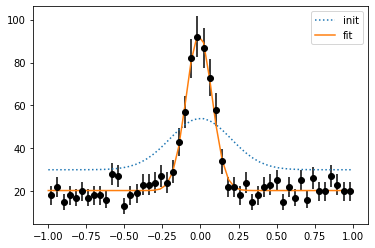

In [6]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(xe[0], xe[-1])
plt.plot(xm, model_density(xm, *[p.value for p in m.init_params])[1] * dx[0],
         ls=":", label="init")
plt.plot(xm, model_density(xm, *m.values)[1] * dx[0], label="fit")
plt.legend();

### Binned Fit

Binned fits are computationally more efficient and numerically more stable when samples are large. The caveat is that one has to choose an appropriate binning. The binning should be fine enough so that the essential information in the original is retained.

The sample investigate here is large enough and 50 bins are fine enough to retain all information. The maximum-likelihood method applied to binned data gives correct results even if bins no entries, so chosing a binning that is very fine is not an issue. It just increases the computational cost.

The cost functions for binned fits implemented here assume that the bin contents are independently Poisson distributed around an unknown expected value per bin. This is exactly correct for ordinary histograms.

For a binned maximum-likelihood fit, one sums the logarithm of Poisson probabilities for the observed counts as a function of the predicted counts in this case (times -1 to turn maximization into minimization). Instead of a pdf, you need to provide a cdf in this case (which must be vectorized). Note that you can approximate the cdf as "bin-width times pdf evaluated at center" if it is difficult to calculate, but this is an approxmiation. Using the cdf is exact.

In [7]:
def model_cdf(xe, z, mu, sigma):
    return (z * norm.cdf(xe, mu, sigma) + 
            (1-z) * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.BinnedNLL(n, xe, model_cdf)

m = Minuit(c, z=0.4, mu=0, sigma=0.2)

m.limits["z"] = (0, 1)
m.limits["mu"] = (-1, 1)
m.limits["sigma"] = (0, None)

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 29.74 (chi2/ndof = 0.6)    │              Nfcn = 82               │
│ EDM = 1.88e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.274   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000302 -4.83e-06  4.05e-05 │
│    mu │ -4.83e-06   3.9e-05 -3.26e-06 │
│ sigma │  4.05e-05 -3.26e-06  3.49e-05 │
└───────┴───────────────────────────────┘

The fitted values and the uncertainty estimates for $\mu$ and $\sigma$ are not identical to the unbinned fit, but very close. For practical purposes, the results are equivalent. This shows that the binning is fine enough to retain the essential information in the original data.

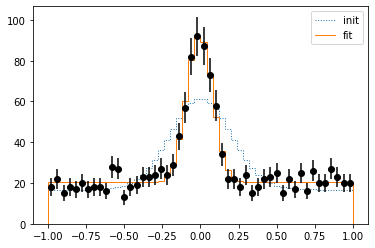

In [8]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_cdf(xe, *[p.value for p in m.init_params])) * len(xdata), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_cdf(xe, *m.values)) * len(xdata), xe, label="fit")
plt.legend();

### Extended binned maximum-likelihood fit

The binned extended maximum-likelihood fit is strictly the binned equivalent of the corresponding unbinned fit. One sums the logarithm of Poisson probabilities for the observed counts as a function of the predicted counts in this case (times -1 to turn maximization into minimization).

Instead of a density, you need to provide a cdf of the density in this case (which must be vectorized). There is no need to separately return the total integral like the unbinned case. The parameters are the same as in the unbinned extended fit.

In [9]:
def model_density_cdf(xe, nsig, nbkg, mu, sigma):
    return (nsig * norm.cdf(xe, mu, sigma) +
            nbkg * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedBinnedNLL(n, xe, model_density_cdf)

m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)

m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 29.74 (chi2/ndof = 0.6)    │              Nfcn = 119              │
│ EDM = 6.67e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    383    │    26     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
│ 2 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      nsig      nbkg        mu     sigma │
├───────┼─────────────────────────────────────────┤
│  nsig │       696      -313  -0.00675    0.0567 │
│  nbkg │      -313  1.33e+03   0.00675   -0.0567 │
│    mu │  -0.00675   0.00675  3.89e-05 -3.24e-06 │
│ sigma │    0.0567   -0.0567 -3.24e-06  3.48e-05 │
└───────┴─────────────────────────────────────────┘

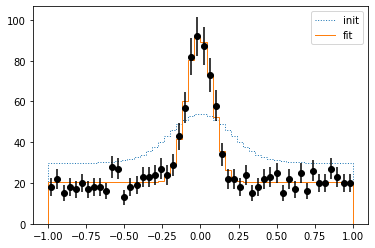

In [10]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label="fit")
plt.legend();

The fitted values and the uncertainty estimates for $\mu$ and $\sigma$ are identical to the ordinary ML fit.

### Temporary masking

In complicated binned fits with peak and background, it is sometimes useful to fit in several stages. One typically starts by masking the signal region, to fit only the background region.

The cost functions have a mask attribute to that end. We demonstrate the use of the mask with an extended binned fit.

In [11]:
def model_density_cdf(xe, nsig, nbkg, mu, sigma):
    return (nsig * norm.cdf(xe, mu, sigma) +
            nbkg * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedBinnedNLL(n, xe, model_density_cdf)

# we set the signal amplitude to zero and fix all signal parameters
m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)

m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)
m.fixed["nsig", "mu", "sigma"] = True

# we temporarily mask out the signal
c.mask = (cx < -0.5) | (0.5 < cx)

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.28 (chi2/ndof = 0.8)    │              Nfcn = 20               │
│ EDM = 2.39e-10 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    300    │     3     │            │            │    0    │         │  yes  │
│ 1 │ nbkg  │  1.00e3   │  0.05e3   │            │            │    0    │         │       │
│ 2 │ mu    │    0.0    │    0.1    │            │            │   -1    │    1    │  yes  │
│ 3 │ sigma │   0.200   │   0.002   │            │            │    0    │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────┐
│       │    nsig    nbkg      mu   sigma │
├───────┼─────────────────────────────────┤
│  nsig │       0       0       0       0 │
│  nbkg │       0 2.1e+03       0       0 │
│    mu │       0       0       0       0 │
│ sigma │       0       0       0       0 │
└───────┴─────────────────────────────────┘

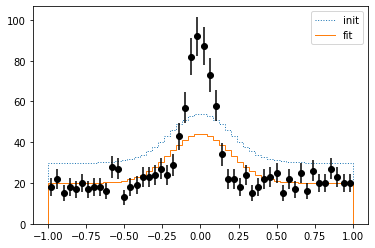

In [12]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label="fit")
plt.legend();

Now we fix the background and fit only the signal parameters.

In [13]:
c.mask = None # remove mask
m.fixed = False # release all parameters
m.fixed["nbkg"] = True # fix background amplitude

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 29.86 (chi2/ndof = 0.6)    │              Nfcn = 91               │
│ EDM = 8.78e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    386    │    25     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.00e3   │  0.05e3   │            │            │    0    │         │  yes  │
│ 2 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      nsig      nbkg        mu     sigma │
├───────┼─────────────────────────────────────────┤
│  nsig │       625         0  -0.00529    0.0439 │
│  nbkg │         0         0         0         0 │
│    mu │  -0.00529         0   3.9e-05 -3.02e-06 │
│ sigma │    0.0439         0 -3.02e-06  3.29e-05 │
└───────┴─────────────────────────────────────────┘

Finally, we release all parameters and fit again to get the correct uncertainty estimates.

In [14]:
m.fixed = None
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 29.74 (chi2/ndof = 0.6)    │              Nfcn = 158              │
│ EDM = 5.84e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    383    │    26     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
│ 2 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      nsig      nbkg        mu     sigma │
├───────┼─────────────────────────────────────────┤
│  nsig │       696      -313  -0.00676    0.0567 │
│  nbkg │      -313  1.33e+03   0.00676   -0.0567 │
│    mu │  -0.00676   0.00676  3.89e-05 -3.26e-06 │
│ sigma │    0.0567   -0.0567 -3.26e-06  3.49e-05 │
└───────┴─────────────────────────────────────────┘

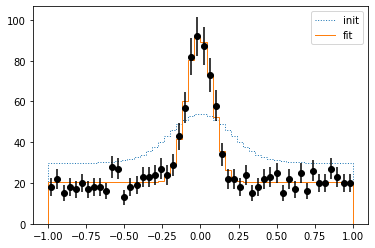

In [15]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label="fit")
plt.legend();

We get the same result, of course. Since this was an easy problem, we did not need these extra steps, but doing this is usually helpful to fit lots of histograms without adjusting each fit manually.

### Weighted histograms

The cost functions for binned data also support weighted histograms. Just pass an array with the shape `(n, 2)` instead of `(n,)` as the first argument, where the first number of each pair is the sum of weights and the second is the sum of weights squared (an estimate of the variance of that bin value).

## Least-squares fits

A cost function for a general weighted least-squares fit (aka chi-square fit) is also included. In statistics this is called non-linear regression.

In this case you need to provide a model that predicts the y-values as a function of the x-values and the parameters. The fit needs estimates of the y-errors. If those are wrong, the fit may be biased. If your data has errors on the x-values as well, checkout the tutorial about automatic differentiation, which includes an application of that to such fits.

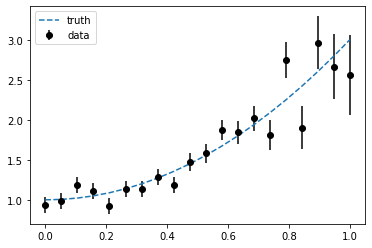

In [16]:
def model(x, a, b):
    return a + b * x ** 2

rng = np.random.default_rng(4)

x = np.linspace(0, 1, 20)
yt = model(x, 1, 2)
ye = 0.4 * x**5 + 0.1
y = rng.normal(yt, ye)

plt.plot(x, yt, ls="--", label="truth")
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.legend();

In [17]:
c = cost.LeastSquares(x, y, ye, model)

m = Minuit(c, a=0, b=0)
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 25.29 (chi2/ndof = 1.4)    │              Nfcn = 29               │
│ EDM = 2.27e-22 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.99    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.04    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00139 -0.00369 │
│ b │ -0.00369   0.0226 │
└───┴───────────────────┘

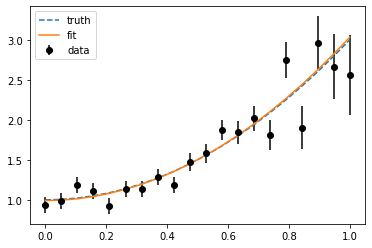

In [18]:
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.plot(x, model(x, 1, 2), ls="--", label="truth")
plt.plot(x, model(x, *m.values), label="fit")
plt.legend();

### Robust least-squares

The builtin least-squares function also supports robust fitting with alternative loss functions. See the documentation of `iminuit.cost.LeastSquares` for details. Users can pass their own loss functions. Builtin loss functions are:

* `linear` (default): gives ordinary weighted least-squares
* `soft_l1`: quadratic ordinary loss for small deviations ($\ll 1\sigma$), linear loss for large deviations ($\gg 1\sigma$), and smooth interpolation in between

Let's create one outlier and see what happens with ordinary loss.

In [19]:
def model(x, a, b):
    return a + b * x ** 2

rng = np.random.default_rng(4)

x = np.linspace(0, 1, 20)
yt = model(x, 1, 2)
ye = 0.4 * x**5 + 0.1
y = rng.normal(yt, ye)
y[3] = 3 # generate an outlier

c = cost.LeastSquares(x, y, ye, model)

m = Minuit(c, a=0, b=0)
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 364.9 (chi2/ndof = 20.3)   │              Nfcn = 29               │
│ EDM = 9.85e-22 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.23    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   1.45    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00139 -0.00369 │
│ b │ -0.00369   0.0226 │
└───┴───────────────────┘

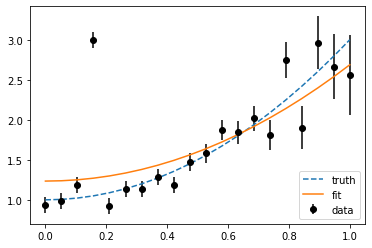

In [20]:
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.plot(x, model(x, 1, 2), ls="--", label="truth")
plt.plot(x, model(x, *m.values), label="fit")
plt.legend();

The result is distorted by the outlier. We can repair this with the `soft_l1` loss.

In [21]:
c.loss = "soft_l1"
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 54.09 (chi2/ndof = 3.0)    │              Nfcn = 69               │
│ EDM = 4.31e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.00    │   0.05    │            │            │         │         │       │
│ 1 │ b    │   2.04    │   0.23    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00285 -0.00864 │
│ b │ -0.00864   0.0524 │
└───┴───────────────────┘

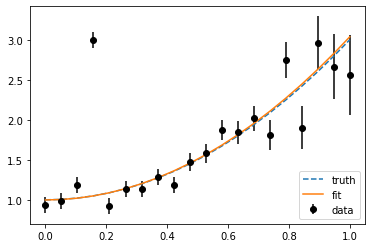

In [22]:
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.plot(x, model(x, 1, 2), ls="--", label="truth")
plt.plot(x, model(x, *m.values), label="fit")
plt.legend();

The result is now practically identical as in the previous case without an outlier.

Robust fitting is a very powerful if the data are contaminated with small amounts of outliers. It comes with a price, however, the uncertainties are in general larger. Compare the estimated uncertainty of the parameter $b$, which was 0.15 and now is 0.23.

We can actually do better by manually removing the point (using the mask attribute) and switching back to ordinary loss.

In [23]:
c.mask = c.x != c.x[3]
c.loss = "linear"
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 24.67 (chi2/ndof = 1.5)    │              Nfcn = 100              │
│ EDM = 1.36e-23 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.98    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.07    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00158 -0.00415 │
│ b │ -0.00415   0.0238 │
└───┴───────────────────┘

Now the uncertainty on $b$ is back to 0.15.